# Higher rank batch dimensions on Fields

Our `Field` objects always have a batch dimension, which makes certain kinds of computations easier (e.g. propagation to multiple depths) without having to add extra dimensions all the time. However, this is not flexible enough for every use case, such as propagation of multiple input fields to multiple depths. This is why we allow more than one batch dimension! A `Field` may have an arbitrary number of batch dimensions (although it is always at least 1), and all of the elements and functions in Chromatix will broadcast appropriately to handle these extra dimensions. This notebook will demonstrate how to use these higher rank batch dimensions, as well as how to customize the broadcasting for trickier cases than what the default behavior allows.

In [1]:
import jax
import jax.numpy as jnp
from flax import linen as nn
from chex import Array
import numpy as np
import matplotlib.pyplot as plt

import chromatix.functional as cx
from chromatix.elements import FFLens, Propagate
from chromatix.systems import OpticalSystem
from chromatix import Field, ScalarField

key = jax.random.PRNGKey(4)

## Creating Fields with more than one batch dimension

The default `ScalarField.create` or `VectorField.create` methods will produce a 5 dimensional `Field` that has only 1 batch dimension if you provide a shape. In order to add batch dimensions, you'll have to create the complex Array yourself:

In [2]:
u = jnp.ones((2, 1, 256, 256, 1, 1))
field = ScalarField.create(0.1, 0.532, 1.0, u=u)
print(field.shape)

(2, 1, 256, 256, 1, 1)


Note that this still means that every element of the batch, no matter how many batch dimensions there are, **will all have the same spectrum and spacing**!

## Using higher rank Fields

We have created a `Field` here that has two batch dimensions. We now have a batch of two `Field`s with the usual 5 dimensions. Let's see what happens if we try to propagate this higher rank batched `Field` to 5 z values after passing through a lens:

In [3]:
system = OpticalSystem([
    FFLens(100.0, 1.33, 0.8),
    Propagate(jnp.linspace(-25, 25, num=5), 1.33, cache_propagator=True)
])
params = system.init(key, field)

In [4]:
jax.tree_util.tree_map(lambda x: jnp.array(x).shape, params)

FrozenDict({
    state: {
        elements_0: {
            _NA: (),
            _f: (),
            _n: (),
        },
        elements_1: {
            _n: (),
            _z: (5,),
            kernel: (1, 5, 256, 256, 1, 1),
        },
    },
})

In [5]:
result = system.apply(params, field)

In [6]:
result.shape

(2, 5, 256, 256, 1, 1)

We can see that the result is that the resulting 5 depths were broadcasted to the innermost batch dimension, i.e. the original batch dimension. We still have the outer batch dimension of 2. We can see that in this case, the results are identical because each element of the outer batch of 2 was propagated to the same 5 z values:

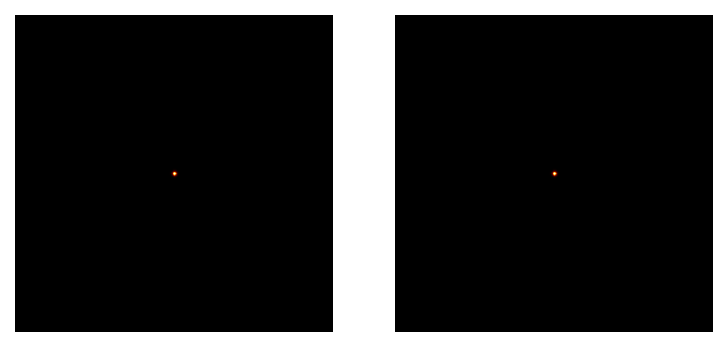

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=1, dpi=150)
ax = axes[0]
ax.imshow(result.intensity[0, 0].squeeze(), vmin=0, cmap="afmhot")
ax.axis("off")

ax = axes[1]
ax.imshow(result.intensity[1, 0].squeeze(), vmin=0, cmap="afmhot")
ax.axis("off")

plt.show()

## Combining higher rank Fields with vmap

What if we wanted each element of the outer batch of 2 to be propagated to different z values? The propagation element/functions only accept a 1D array of z values. Luckily, `Field` supports being vmapped, with all its attributes such as `dx` or `spectrum` having their shapes appropriately rearranged dynamically. That means you can simply use `jax.vmap` on a function like so:

In [8]:
@jax.vmap
def vmapped_system(field: Field, zs: Array) -> Field:
    field = cx.ff_lens(field, 100.0, 1.33, 0.8)
    field = cx.transfer_propagate(field, zs, 1.33, 0)
    return field

# Using a stack of z values to propagate each element of the batch
# to different z values using our vmapped function above
result = vmapped_system(field, jnp.stack([jnp.linspace(0, 25, num=5), jnp.linspace(-25, 25, num=5)]))

In [9]:
result.shape

(2, 5, 256, 256, 1, 1)

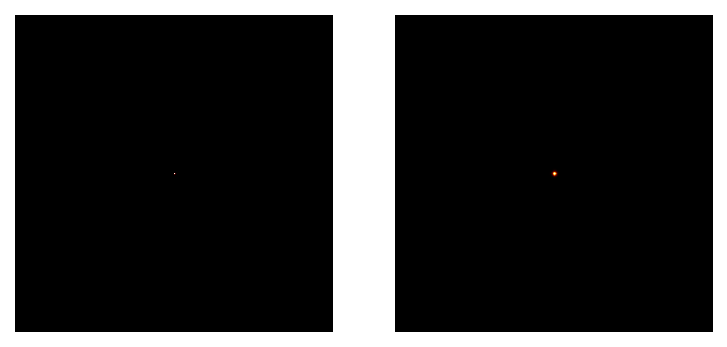

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=1, dpi=150)
ax = axes[0]
ax.imshow(result.intensity[0, 0].squeeze(), vmin=0, cmap="afmhot")
ax.axis("off")

ax = axes[1]
ax.imshow(result.intensity[1, 0].squeeze(), vmin=0, cmap="afmhot")
ax.axis("off")

plt.show()

And now we see that the propagation was different for each element of the outer batch!